# NeuralProphet Nuovi Positivi, Terapia Intensiva, Deceduti

In questo notebook sono stati utlizzati gli stessi dati del notebook https://colab.research.google.com/github/marco-mazzoli/progetto-tesi/blob/master/covid_multi_output.ipynb, ossia quelli regionali dell'Emilia-Romagna.
Sono in particolare stati usati i dati di ricoverati in terapia intensiva, deceduti e nuovi positivi fino al 6 Dicembre 2021.

Il modello NeuralProphet è stato utilizzato in modalità univariate ed autoregressiva con lag di 28 giorni per fare forecasting di 1, 2, 7 e 14 giorni.

L'ultimo 20% dei dati è stato escluso dalla fase di ricerca degli iper-parametri. Una volta stabiliti è stato usato l'intero dataset per fare previsione mantendo il primo 80% di train e il restante di test.

Gli iper-parametri su cui è stata fatta la ricerca sono learning-rate e numero di layer hidden della rete neurale.

Prima della fase di train i dati vengono scalati per poi essere riportati alla scala originale una volta effettuata la previsione.

Questo modello crea automaticamente i lag temporali.

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install neuralprophet

In [ ]:
import os

if 'google.colab' in str(get_ipython()):
    files = ['util.py',
             'windows.py',
             'models']

    for file in files:
        os.system('rm ./' + file)
        os.system(
            'wget -nv https://raw.githubusercontent.com/marco-mazzoli/progetto-tesi/master/' + file)

import pandas as pd
from numpy.random import seed
from neuralprophet import NeuralProphet

from util import select_relevant_rows, select_attributes



In [ ]:
use_existing_config = True
column_to_predict = 'terapia_intensiva'
columns = ['nuovi_positivi', 'terapia_intensiva', 'deceduti']
split_percent = 0.80
region_focus = 'Emilia-Romagna'
attribute_focus = 'denominazione_regione'
n_futures = [1, 2, 7, 14]


In [ ]:
local_region_path = r'../COVID-19/dati-regioni/dpc-covid19-ita-regioni.csv'
remote_region_path = r'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'

regions_frame = pd.read_csv(remote_region_path)

region_focus_data = select_relevant_rows(
    regions_frame,
    attribute_focus,
    region_focus
)

df = select_attributes(region_focus_data, [
    'data',
    'ricoverati_con_sintomi',
    'terapia_intensiva',
    'totale_ospedalizzati',
    'variazione_totale_positivi',
    'nuovi_positivi',
    'deceduti',
    'tamponi',
    'ingressi_terapia_intensiva'
])

df = pd.DataFrame(df)
df['data'] = pd.to_datetime(
    df['data'])
df['data'] = df['data'].dt.strftime(
    r'%Y-%m-%d')
df['data'] = pd.to_datetime(df['data'])
df = df[df['data'] < pd.to_datetime('2021-12-22')]
df = df.fillna(0)

mobility_data_url = r'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'
file_path = r'../Global_Mobility_Report.csv'
mobility_data_zip_url = r'https://www.gstatic.com/covid19/mobility/Region_Mobility_Report_CSVs.zip'
zip_path = r'../Region_Mobility_Report_CSVs.zip'
region_mobility_path = r'../Region_Mobility_Report_CSVs'

df.rename(columns={'data': 'date'}, inplace=True)
df.set_index('date', inplace=True)

# revert cumulative data
df['deceduti'] = df['deceduti'].diff(
)
df['tamponi'] = df['tamponi'].diff(
)

df = df.astype('float')

# numpy seed
seed(1)

In [ ]:
def define_np_configs():
    learning_rate = [0.001, 0.01, 0.05, 0.1]
    n_hidden = [0, 1, 2]

    configs = []
    keys = ['learning_rate', 'n_hidden']

    for i in learning_rate:
        for j in n_hidden:   
            config = dict(
                zip(keys, (i, j)))
            configs.append(config)

    return configs

INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.021 701.634 718.242
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.001 165.323 186.769
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss      MAE     RMSE
1         0.089 1433.341 1463.629
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.000 74.615 89.293
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss     MAE    RMSE
1         0.003 237.844 288.499
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 

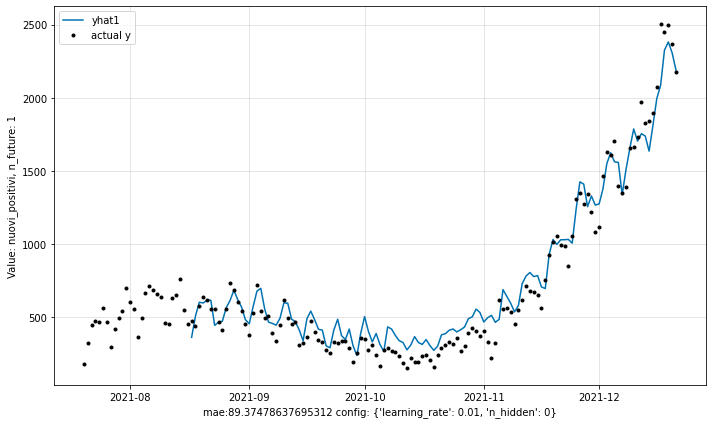

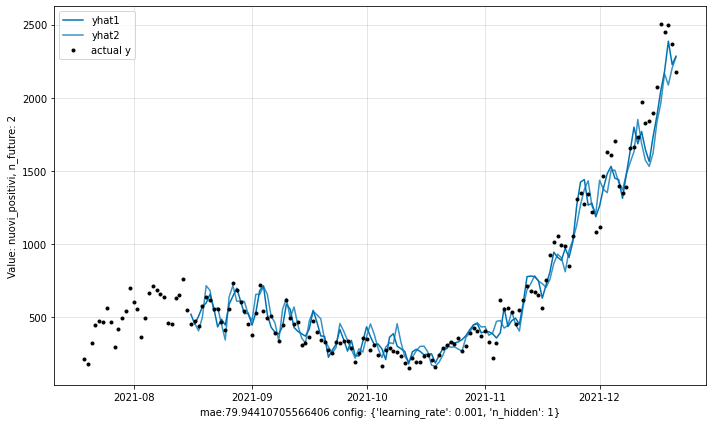

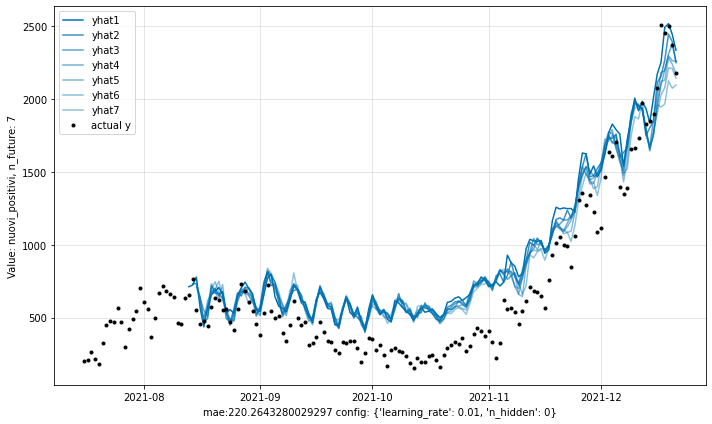

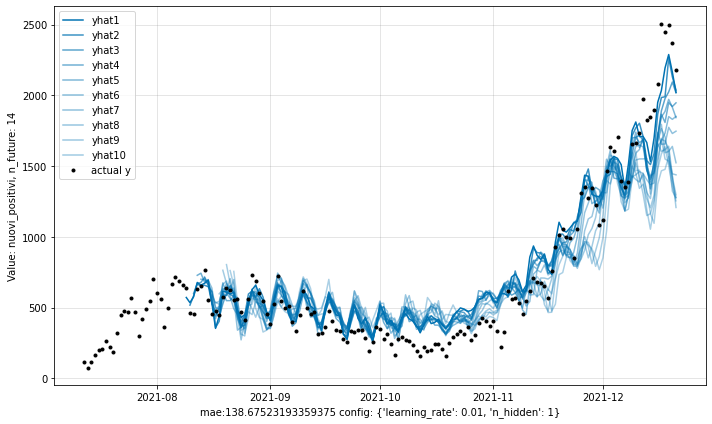

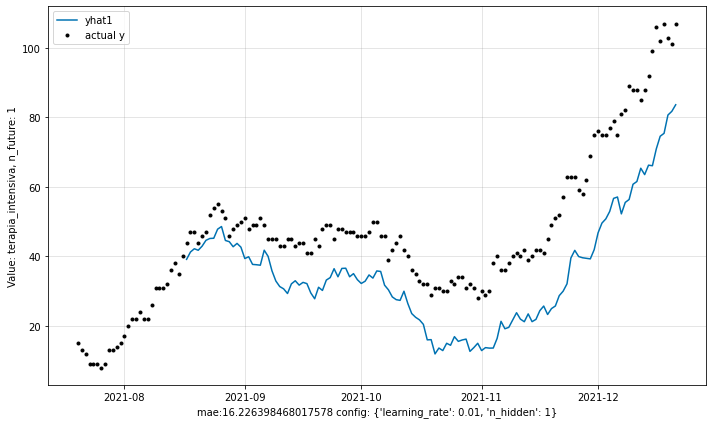

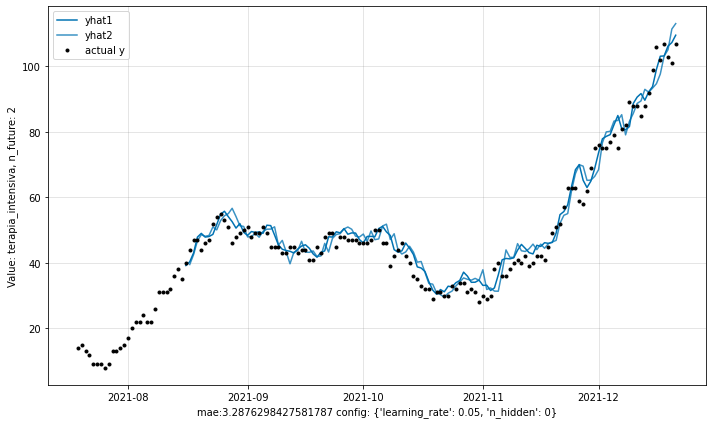

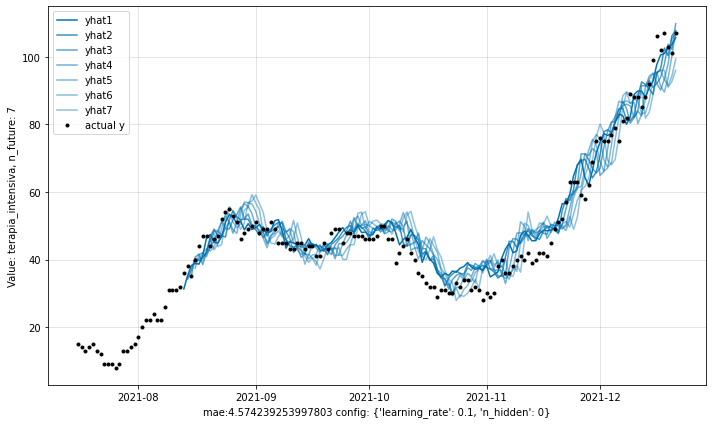

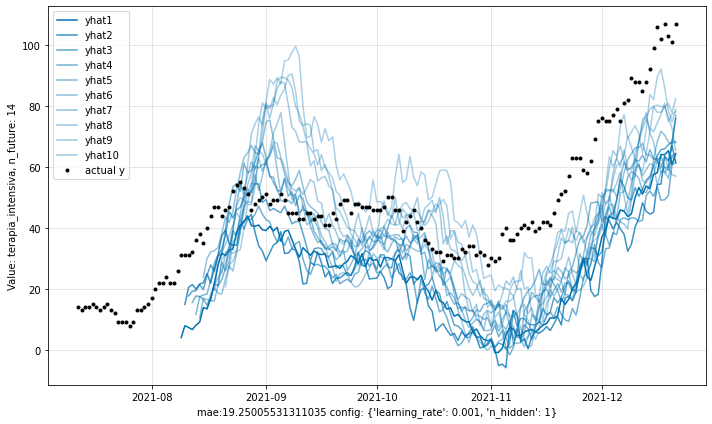

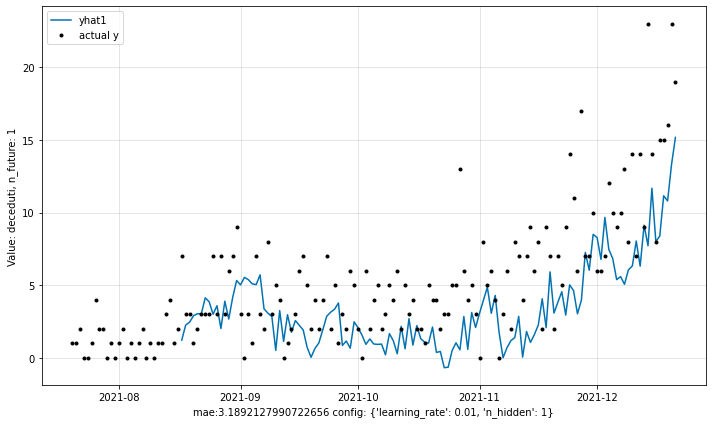

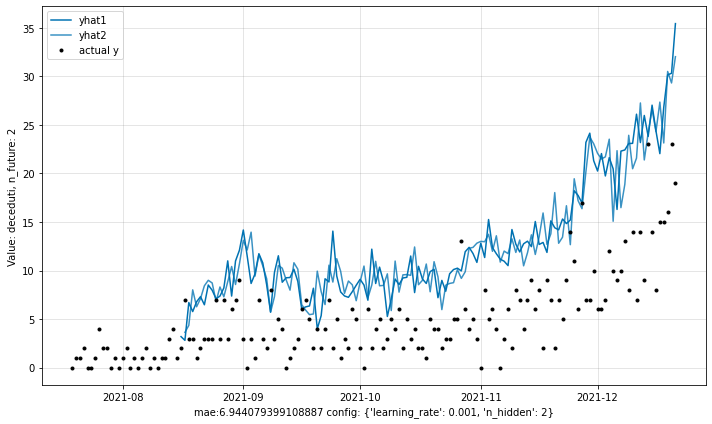

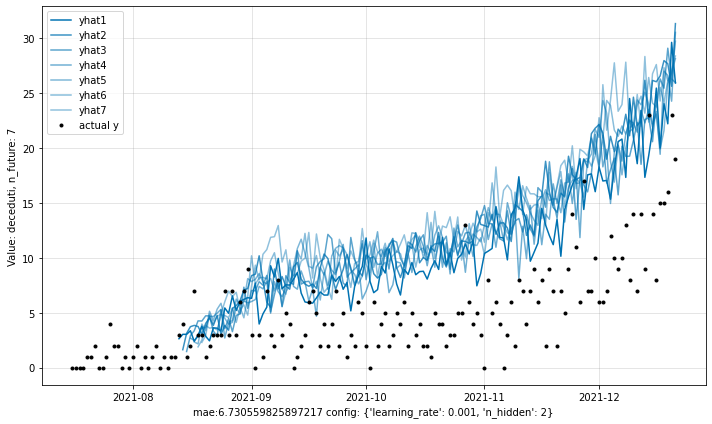

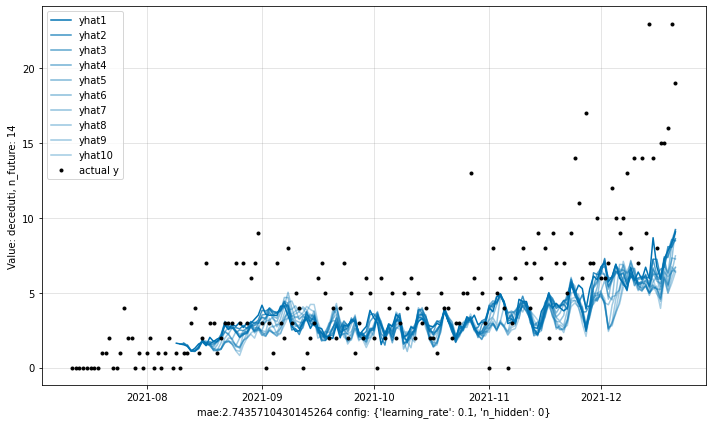

In [ ]:
table_result = pd.DataFrame(columns=['mae'])

for column_to_predict in columns:
    for n_future in n_futures:
        split = int(split_percent * len(df))
        
        current = df[[column_to_predict]].reset_index().copy()
        current.columns = ['ds', 'y']

        holdout = current[:split]
        results = []

        for config in define_np_configs():
            m = NeuralProphet(
                n_lags=28,
                epochs=200,
                n_forecasts=n_future,
                weekly_seasonality=False,
                changepoints_range=1,
                daily_seasonality=False,
                yearly_seasonality=False,
                learning_rate=config['learning_rate'],
                num_hidden_layers=config['n_hidden'],
                normalize='minmax'
            )

            df_train, df_test = m.split_df(df=holdout, freq="D", valid_p=1-split_percent)

            metrics_train = m.fit(df=df_train, validation_df=df_test,freq="D", progress_print=False, progress_bar=False)
            metrics_test = m.test(df=df_test)

            mae = metrics_test['MAE'][0]

            results.append((mae, config))
    
        results.sort()
        best_config = results[0][-1]

        m = NeuralProphet(
            n_lags=28,
            epochs=200,
            n_forecasts=n_future,
            weekly_seasonality=False,
            changepoints_range=1,
            daily_seasonality=False,
            yearly_seasonality=False,
            learning_rate=best_config['learning_rate'],
            num_hidden_layers=best_config['n_hidden'],
            normalize='minmax'
        )

        df_train, df_test = m.split_df(df=current, freq="D", valid_p=1-split_percent)

        metrics_train = m.fit(df=df_train, validation_df=df_test,freq="D", progress_print=False, progress_bar=False)
        metrics_test = m.test(df=df_test)

        forecast = m.predict(df=df_test)

        mae = metrics_test['MAE'][0]
        ylabel = 'Value: ' + column_to_predict + ', n_future: ' + str(n_future)
        xlabel =  'mae:' + str(mae) + ' config: ' + str(best_config)
        m.plot(forecast, ylabel=ylabel, xlabel=xlabel)

        values_to_add = {'mae': mae}
        row_to_add = pd.Series(values_to_add, name = column_to_predict + ' ' + str(n_future))

        table_result = table_result.append(row_to_add)


In [ ]:
table_result

,mae
nuovi_positivi 1,89.374786
nuovi_positivi 2,79.944107
nuovi_positivi 7,220.264328
nuovi_positivi 14,138.675232
terapia_intensiva 1,16.226398
terapia_intensiva 2,3.287630
terapia_intensiva 7,4.574239
terapia_intensiva 14,19.250055
deceduti 1,3.189213
deceduti 2,6.944079


##Risultati

###Deceduti
|    | LSTM                           | XGBoost                        | ARIMA                          | Informer                       | NeuralProphet                       |
|----|--------------------------------|--------------------------------|--------------------------------|--------------------------------|--------------------------------|
| 1  | Avg MAE: 3.18  <br />Best Slot: 0.03 | Avg MAE: 2.78  <br />Best Slot: 0.02 | Avg MAE: **2.42**  <br />Best Slot: 0.01 | Avg MAE: **2.26**  <br />Best Slot: 0.008| Avg MAE: 3.18 |
| 2  | Avg MAE: 4.03  <br />Best Slot: 0.33 | Avg MAE: 2.97  <br />Best Slot: 0.11 | Avg MAE: **2.45**  <br />Best Slot: 0.44 | Avg MAE: **2.35**  <br />Best Slot: 0.08 | Avg MAE: 6.94 |
| 7  | Avg MAE: **2.51**  <br />Best Slot: 1.01 | Avg MAE: 3.30  <br />Best Slot: 1.19 | Avg MAE: 2.53  <br />Best Slot: 1.06 | Avg MAE: 2.70  <br />Best Slot: 1.20 | Avg MAE: 6.73  |
| 14 | Avg MAE: 6.22  <br />Best Slot: 3.49 | Avg MAE: 3.31  <br />Best Slot: 1.62 | Avg MAE: **2.50**  <br />Best Slot: 1.21 | Avg MAE: 4.02  <br />Best Slot: 1.74 | Avg MAE: 2.75   |


###Terapia Intensiva
|    | LSTM                           | XGBoost                        | ARIMA                          | Informer                       | NeuralProphet                       |
|----|--------------------------------|--------------------------------|--------------------------------|--------------------------------|--------------------------------|
| 1  | Avg MAE: 4.36  <br />Best Slot: 0.03 | Avg MAE: 3.21  <br />Best Slot: 0.002 | Avg MAE: **2.31**  <br />Best Slot: 0.02 | Avg MAE: 13.61  <br />Best Slot: 1.53| Avg MAE: 16.22  |
| 2  | Avg MAE: 5.83  <br />Best Slot: 1.08 | Avg MAE: 4.55  <br />Best Slot: 0.47 | Avg MAE: **2.87**  <br />Best Slot: 0.05 | Avg MAE: 5.17  <br />Best Slot: 0.54 | Avg MAE: 3.28   |
| 7  | Avg MAE: 11.09  <br />Best Slot: 1.95 | Avg MAE: 7.03  <br />Best Slot: 1.89 | Avg MAE: 4.73  <br />Best Slot: 1.05 | Avg MAE: 8.53  <br />Best Slot: 2.88 | Avg MAE: **4.57**  |
| 14 | Avg MAE: 13.17  <br />Best Slot: 5.95 | Avg MAE: 9.37  <br />Best Slot: 2.96 | Avg MAE: **6.86**  <br />Best Slot: 1.22 | Avg MAE: 15.38  <br />Best Slot: 8.00| Avg MAE: 19.25   |

###Nuovi Positivi
|    | LSTM                              | XGBoost                           | ARIMA                             | Informer                       | NeuralProphet                       |
|----|-----------------------------------|-----------------------------------|-----------------------------------|--------------------------------|--------------------------------|
| 1  | Avg MAE: 118.94  <br />Best Slot: 0.03  | Avg MAE: 74.04  <br />Best Slot: 0.56   | Avg MAE: **57.19**  <br />Best Slot: 0.07   | Avg MAE: 118.74  <br />Best Slot: 1.82 | Avg MAE: 89.37  |
| 2  | Avg MAE: 113.78  <br />Best Slot: 6.82  | Avg MAE: 88.25  <br />Best Slot: 6.17   | Avg MAE: **65.80**  <br />Best Slot: 3.98   | Avg MAE: 90.73   <br />Best Slot: 4.62   | Avg MAE: 79.94  |
| 7  | Avg MAE: 132.39  <br />Best Slot: 33.74 | Avg MAE: 113.55  <br />Best Slot: 28.43 | Avg MAE: **85.05**  <br />Best Slot: 16.71  | Avg MAE: 162.37  <br />Best Slot: 41.94  | Avg MAE: 220.26  |
| 14 | Avg MAE: 156.96  <br />Best Slot: 48.71 | Avg MAE: 169.45  <br />Best Slot: 27.14 | Avg MAE: **114.03**  <br />Best Slot: 22.81 | Avg MAE: 529.82  <br />Best Slot: 351.47 | Avg MAE: 138.67   |

ARIMA mantiene un errore di previsione inferiore rispetto agli altri modelli in tutti gli scenari tranne per:
- Orizzonte deceduti di 7 giorni in cui LSTM ha MAE inferiore
- Orizzonte 1 e 2 giorni di deceduti in cui Informer ha un errore inferiore
- Terapia intensiva con orizzonte 7 giorni in cui l'errore inferiore è con NerualProphet.

